In [1]:
from PIL import Image
import numpy as np

import gym
import gym_snake

from skimage.color import rgb2gray
from skimage.transform import resize
from tqdm import tqdm, tqdm_notebook

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, \
    Convolution2D, Permute, Input, Lambda
from keras.optimizers import Adam
import keras.backend as K

from keras.models import model_from_config
import tensorflow as tf
from collections import deque
import random

from IPython.display import display

from PIL import Image

%matplotlib inline

Using TensorFlow backend.


In [2]:
ENV_NAME = 'snake-v0'  # Environment name
FRAME_WIDTH = 84  # Resized frame width
FRAME_HEIGHT = 84  # Resized frame height
INPUT_SHAPE = (FRAME_WIDTH, FRAME_HEIGHT)
WINDOW_LENGTH = 4  # Number of most recent frames to produce the input to the network (WINDOW LENGTH)

NUM_STEPS = 6_000_005

EXPLORATION_STEPS = 4_500_005  #  Number of steps over which the initial value # of epsilon is linearly annealed to its final value
INITIAL_EPSILON = 1.0  # Initial value of epsilon in epsilon-greedy
FINAL_EPSILON = 0.1  # Final value of epsilon in epsilon-greedy

OBSERVE = 20_000  # Number of steps to populate the replay memory before training starts
NUM_REPLAY_MEMORY = 400_000  # Number of replay memory the agent uses for training
BATCH_SIZE = 32  # Mini batch size
TARGET_UPDATE_INTERVAL = 10_000  # The frequency with which the target network is updated
TRAIN_INTERVAL = 4  # The agent selects 4 actions between successive updates

LEARNING_RATE = 0.00025  # Learning rate used by optimizer
GAMMA = 0.99  # Discount factor

SAVE_INTERVAL = 200_000  # The frequency with which the network is saved
NO_OP_STEPS = 7  # Maximum number of "do nothing" actions to be performed by the agent at the start of an episode

SAVE_NETWORK_PATH = 'saved_networks/' + ENV_NAME
SAVE_SUMMARY_PATH = 'summary/' + ENV_NAME

In [4]:
def get_env():
    env = gym.make(ENV_NAME)
    # env.n_foods = 
    env.snake_size = 2
    env.n_snakes = 2    
    env.grid_size = [20, 20]
    env.unit_size = 10
    env.unit_gap = 1
    # env.random_init = True
    return env

Grid Size: 

[20 20]

Image shape before pre-processing: 

(200, 200, 3)

Image shape after pre-processing: 

(84, 84)

No. of actions: 

4


Before Preprocessing:

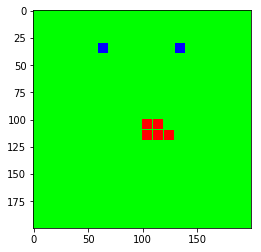


After Preprocessing:

C:\Users\sharan\AppData\Local\Continuum\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


C:\Users\sharan\AppData\Local\Continuum\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


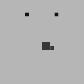

<Figure size 432x288 with 0 Axes>

In [5]:
env = get_env()
x_t = env.reset()

# Controller
game_controller = env.controller
# Grid
grid_object = game_controller.grid
grid_pixels = grid_object.grid
print('Grid Size: ', grid_object.grid_size)
# Snake(s)
snakes_array = game_controller.snakes
snake_object1 = snakes_array[0]

state_shape = grid_pixels.shape
print('Image shape before pre-processing: ', state_shape)
print('Image shape after pre-processing: ', (FRAME_WIDTH, FRAME_HEIGHT))
nb_actions = env.action_space.n
print('No. of actions: ', nb_actions)

print('\nBefore Preprocessing:')
env.render()

print('\nAfter Preprocessing:')

processed_image = np.uint8(resize(rgb2gray(x_t), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
img = Image.fromarray(processed_image)
display(img)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [7]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [54]:
nb_actions = 12
input_shape = (84, 84, 4,)
inp = Input(shape=input_shape)

x5 = Convolution2D(32, (8, 8), strides=(4, 4), activation='relu', name = "ass")(inp)
x1 = Convolution2D(64, (4, 4), strides=(2, 2), activation='relu', name= 'we')(x5)
x2 = Convolution2D(64, (3, 3), strides=(1, 1), activation='relu', name = 'rt')(x1)
flat = Flatten()(x2)
x3 = Dense(512, activation='relu',name = "yt" )(flat)

a1 = Dense(nb_actions, activation='linear')(x3)
a2 = Dense(nb_actions, activation='linear')(x3)

from keras.layers import Concatenate
y = Concatenate()([a1, a2])
#y = a1
model =Model(input=inp, output=y)

print(model.summary())

C:\Users\sharan\AppData\Local\Continuum\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     

input_43 (InputLayer)           (None, 84, 84, 4)    0                                            

__________________________________________________________________________________________________

ass (Conv2D)                    (None, 20, 20, 32)   8224        input_43[0][0]                   

__________________________________________________________________________________________________

we (Conv2D)                     (None, 9, 9, 64)     32832       ass[0][0]                        

__________________________________________________________________________________________________

rt (Conv2D)                     (None, 7, 7, 64)     36928       we[0][0]                         

__________________________________________________________________________________________________

flatten_35 (Flatten)            (None, 3136)         0           rt[0][0]                         

In [9]:

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

# Select a policy. We use eps-greedy action selection, which means that a random action is selected
# with probability eps. We anneal eps from 1.0 to 0.1 over the course of 1M steps. This is done so that
# the agent initially explores the environment (high eps) and then gradually sticks to what it knows
# (low eps). We also set a dedicated eps value that is used during testing. Note that we set it to 0.05
# so that the agent still performs some random actions. This ensures that the agent cannot get stuck.
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

# The trade-off between exploration and exploitation is difficult and an on-going research topic.
# If you want, you can experiment with the parameters or use a different policy. Another popular one
# is Boltzmann-style exploration:
# policy = BoltzmannQPolicy(tau=1.)
# Feel free to give it a try!

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
dqn.compile(Adam(lr=.00025), metrics=['mae'])


C:\Users\sharan\AppData\Local\Continuum\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     

input_43 (InputLayer)           (None, 84, 84, 4)    0                                            

__________________________________________________________________________________________________

ass (Conv2D)                    (None, 20, 20, 32)   8224        input_43[0][0]                   

__________________________________________________________________________________________________

we (Conv2D)                     (None, 9, 9, 64)     32832       ass[0][0]                        

__________________________________________________________________________________________________

rt (Conv2D)                     (None, 7, 7, 64)     36928       we[0][0]                         

__________________________________________________________________________________________________

flatten_35 (Flatten)            (None, 3136)         0           rt[0][0]                         

In [ ]:
# Okay, now it's time to learn something! We capture the interrupt exception so that training
# can be prematurely aborted. Notice that now you can use the built-in Keras callbacks!
weights_filename = 'dqn_{}_weights.h5f'.format(args.env_name)
checkpoint_weights_filename = 'dqn_' + args.env_name + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(args.env_name)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
dqn.fit(env, callbacks=callbacks, nb_steps=1750000, log_interval=10000)

# After training is done, we save the final weights one more time.
dqn.save_weights(weights_filename, overwrite=True)
